------
<h1>
    <center>
        Deep Learning-based Classification/Segmentation<br><br>of Informal Settlement Types<br>
    </center>
</h1>

------


## Notes

* Sentinel 2A imagery data from `COPERNICUS/S2_SR` surface reflectance dataset is the main target dataset for this classification task.
* A Sentinel 2A image covers 13 bands in the visible, near-infrared, and shortwave infrared (SWIR) wavelengths and consists of:
    * four bands at 10 m
    * six bands at 20 m, and
    * three bands at 60 m.

* To select data from the Google Earth Engine (GEE) archive, the filtered collection by date function can be used.
* Multiple images covering a period from 1 May 2023 to 31 May 2023 in the study area could be combined in a GEE collection.
* After filtering by date, a number of `x` images could be obtained that so could be used to form a composite, and a median value was assigned to each pixel.
    * The resulting single image object wwould represent the median value in each band of all the images in the filtered collection.
    * Because clouds appear in different positions in the images, collections are reported in the community to be a powerful way to removing many of the cloud-contaminated pixels.
    * Sentinel-2A image with less than 10% cloud coverage could then be employed.

## Required Packages

In [38]:
import os
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

from skimage import exposure
import rasterio as rio

In [2]:
### Set a base directory
# os.chdir("/Users/ldjeutsch/Urban Malaria Proj Dropbox/urban_malaria/data/nigeria/kano_ibadan")
!ls -hl

total 11136
-rw-r--r--  1 ldjeutsch  staff   2.4M Apr 21 18:28 00-data-preprocessing.ipynb
-rw-r--r--  1 ldjeutsch  staff   2.4M Apr 21 18:27 data-preprocessing.ipynb
-rw-r--r--@ 1 ldjeutsch  staff   581K Apr 19 13:55 image_enhancement.ipynb


#### Extraction of Wards of interest

Based of the two figures above, the main Wards of interest within the two LGAs of interest are the following:
1. LGA 1 - Ibadan North:
   * Bashorun
   * Agodi
2. LGA 2 – Ibadan North East:
   * Agugu
   * Aperin
   * Oke Adu
   * Basorun (due to the overlap with 3 EAs from LGA 1 figure)

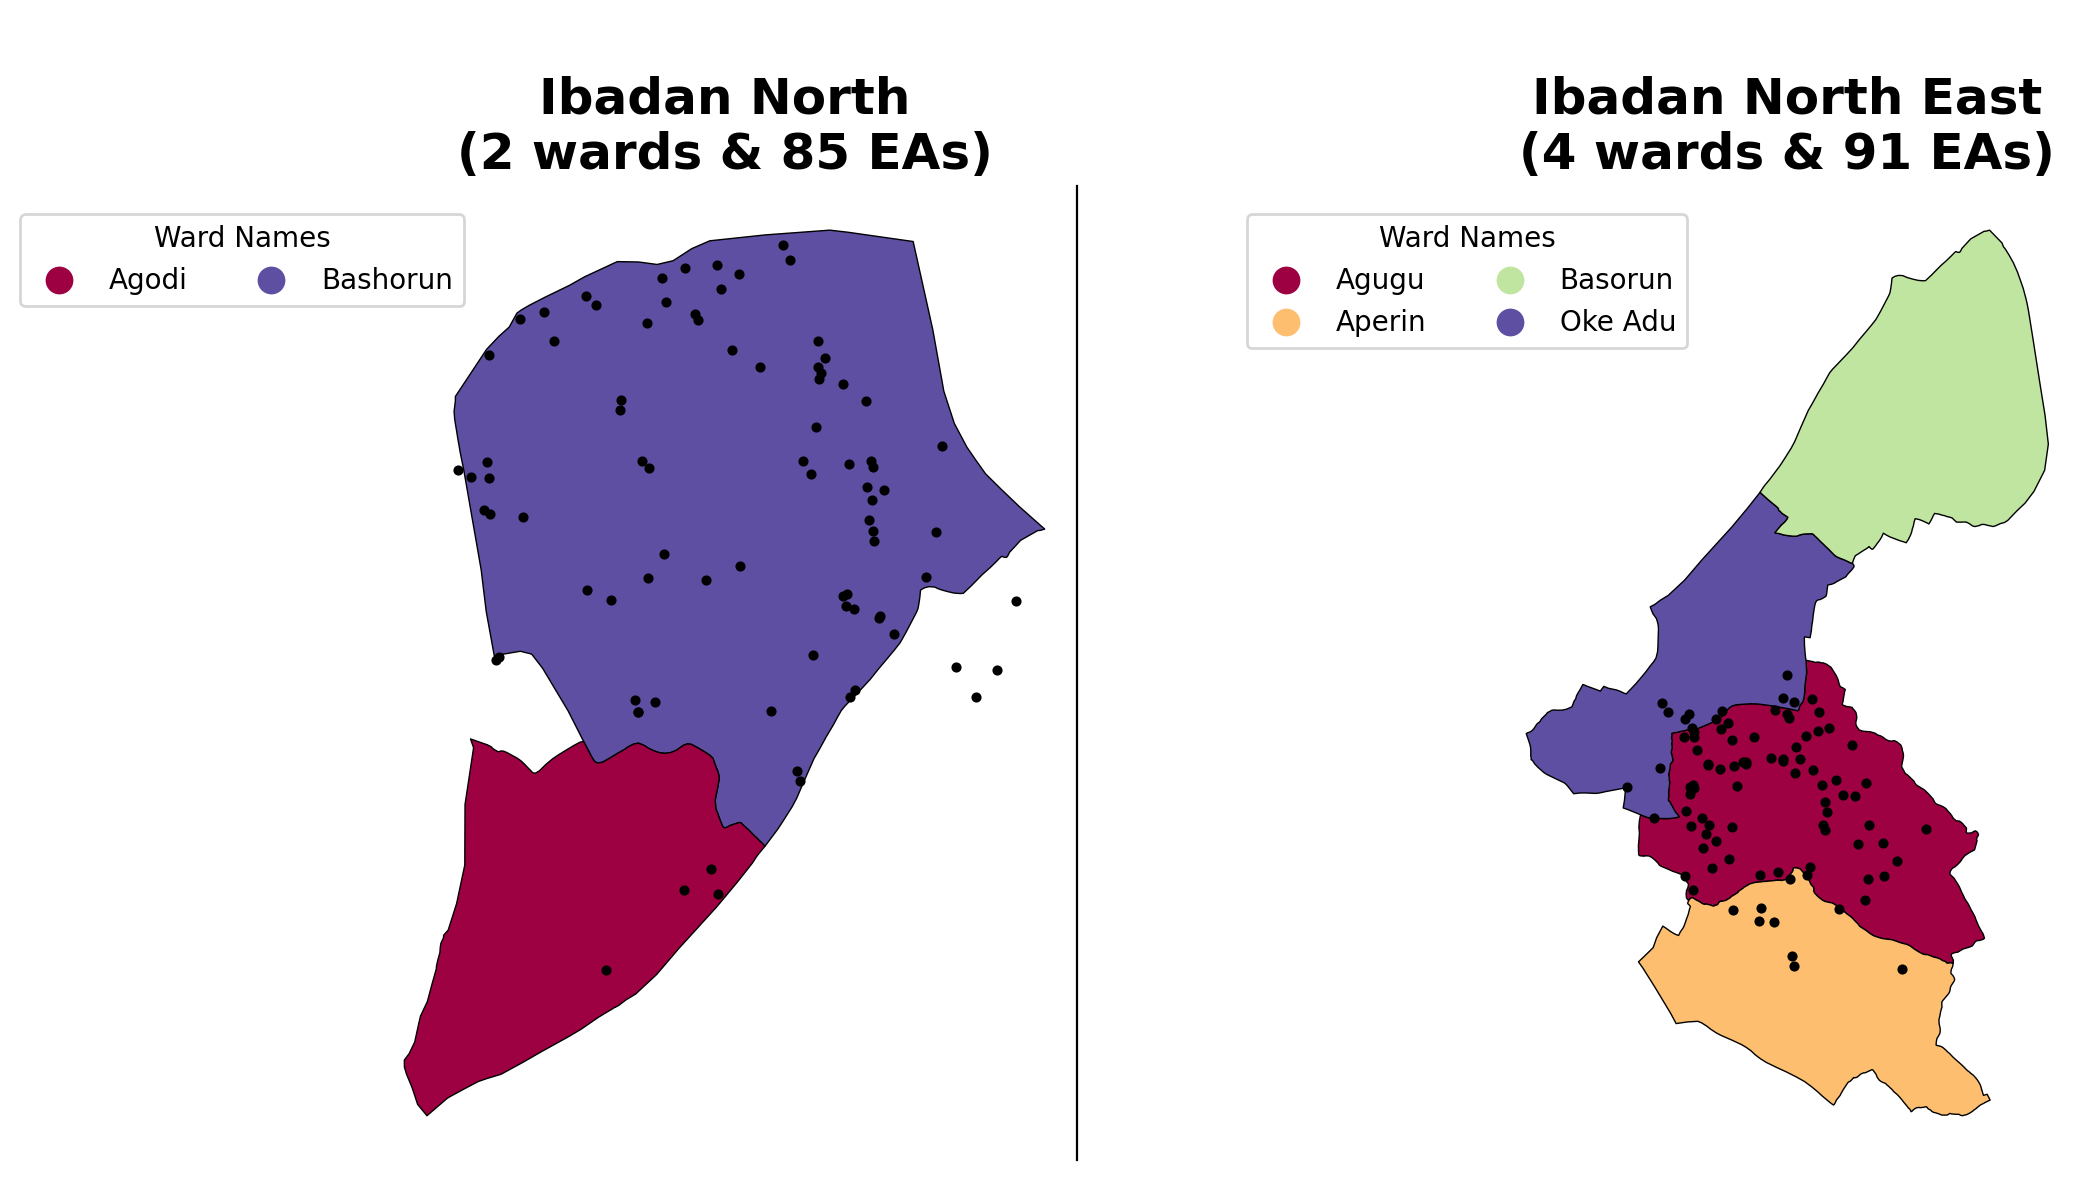

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

Ward_ib_north_AOI.plot(ax=ax[0], column="WardName", cmap="Spectral", legend=True,
                  legend_kwds={'bbox_to_anchor': (.15, .985), "ncol": 2, "title": "Ward Names"},
                  edgecolor="k", linewidth=0.5)
Ward_ib_north_east_AOI.plot(ax=ax[1], column="WardName", cmap="Spectral", legend=True,
                       legend_kwds={'bbox_to_anchor': (.35, .985), "ncol": 2, "title": "Ward Names"},
                       edgecolor="k", linewidth=0.5)
###
Bashorun.plot(ax=ax[0], marker="o", markersize=7, legend=True, color="k")
Agugu.plot(ax=ax[1], marker="o", markersize=7, legend=True, color="k")
###
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
###
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
for edge in ["top", "bottom", "left"]:
    ax[0].spines[edge].set_visible(False)
for edge in ["right", "top", "bottom", "left"]:
    ax[1].spines[edge].set_visible(False)


ax[0].set_title(f"\nIbadan North\n({Ward_ib_north_AOI.WardName.unique().size} wards & {Bashorun.ea_code.unique().size} EAs)",
                fontdict={"size": 18, "weight": "bold"})
ax[1].set_title(f"\nIbadan North East\n({Ward_ib_north_east_AOI.WardName.unique().size} wards & {Agugu.ea_code.unique().size} EAs)",
                fontdict={"size": 18, "weight": "bold"})
fig.tight_layout();

#### Visualize combined Wards and EAs of interest

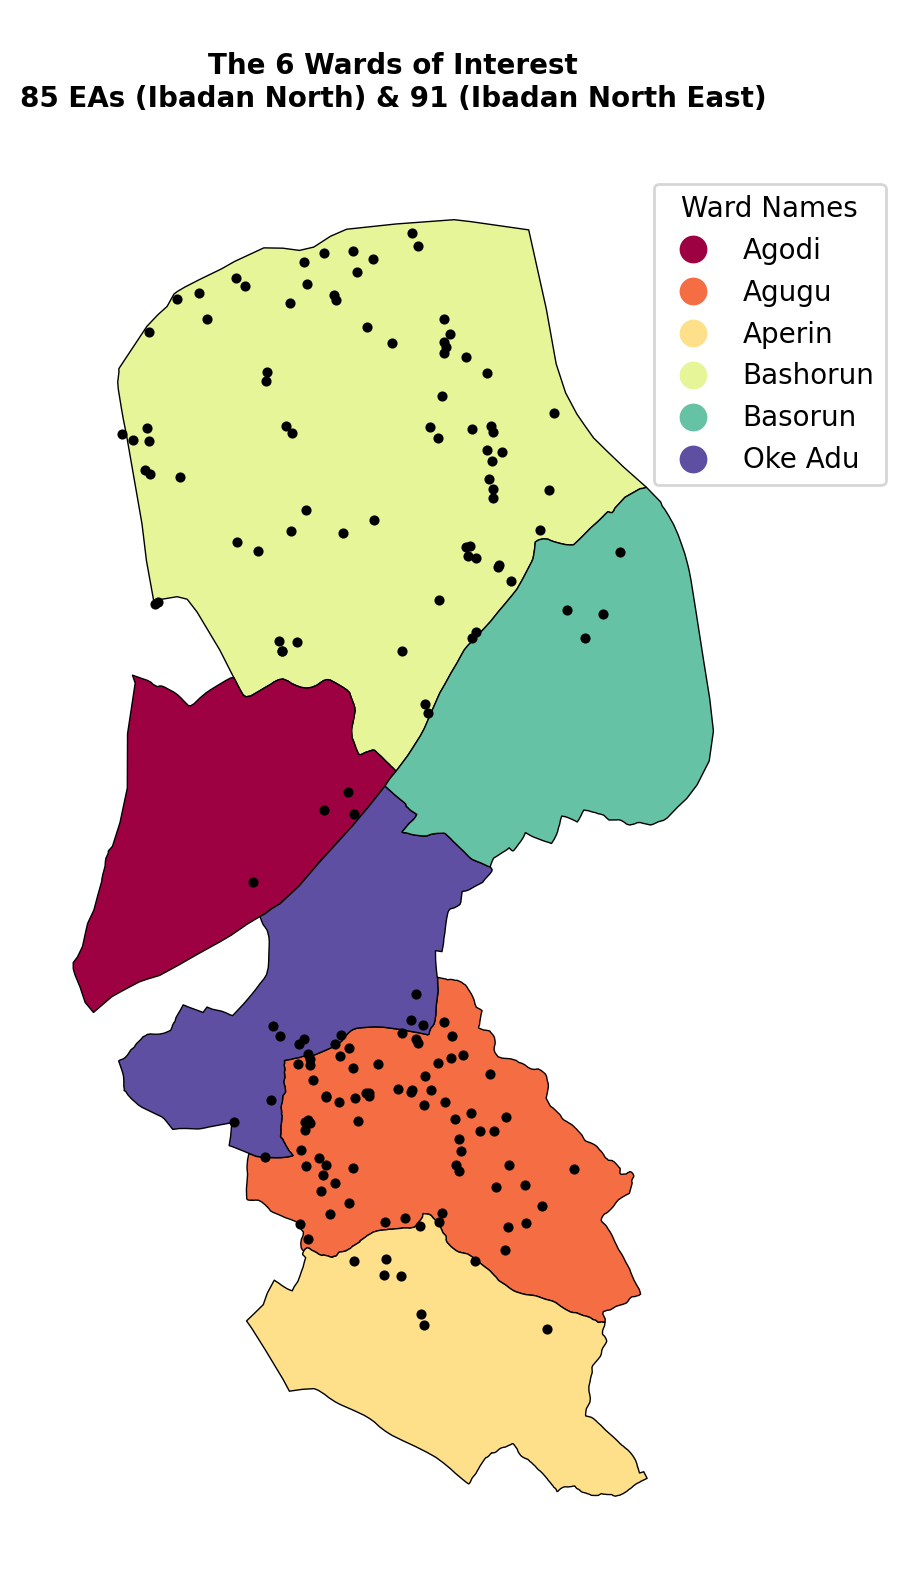

In [29]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=200)

Ward_ib_AOI.plot(ax=ax, column="WardName", cmap="Spectral", legend=True,
                  legend_kwds={'bbox_to_anchor': (.85, .99), "ncol": 1, "title": "Ward Names"},
                  edgecolor="k", linewidth=0.5)
###
Bashorun.plot(ax=ax, marker="o", markersize=7, legend=True, color="k")
Agugu.plot(ax=ax, marker="o", markersize=7, legend=True, color="k")
###
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for edge in ["right", "top", "bottom", "left"]:
    ax.spines[edge].set_visible(False)


ax.set_title(f"\nThe {Ward_ib_AOI.WardName.unique().size} Wards of Interest\n{Bashorun.ea_code.unique().size} EAs (Ibadan North) & {Agugu.ea_code.unique().size} (Ibadan North East)\n",
                fontdict={"size": 10, "weight": "bold"})
# ax.set_title(f"\nIbadan North East\n({Ward_ib_AOI.WardName.unique().size} wards & {Agugu.ea_code.unique().size} EAs)",
#                 fontdict={"size": 18, "weight": "bold"})
fig.tight_layout();

### Save the shapefiles of AOI for Satellite image extractions

In [42]:
### Base directory
shape_dir = "../data-out/aoi-shapefiles"

#### Make the shapefile data of AOI and check CRS

#### Save the extracted shapefile

In [51]:
### input file path
shape_dir = os.path.join(shape_dir, "shapefile_of_Ibadan_LGA_wards_of_interest.shp")

### Test
gdf = gpd.read_file(shape_dir)
gdf

In [53]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

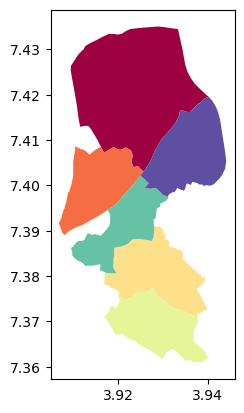

In [54]:
gdf.plot(cmap="Spectral");

In [4]:
import glob

tiles_2020 = glob.glob("../data-in/Sentinel-2/2020_tiff_images/*.tif")
print(f"Number tiles: {len(tiles_2020)}")

Number tiles: 8


In [5]:
# get the random image
img_id = np.random.randint(len(tiles_2020))
# print(img_id)

# # open image with rio
src_raster = rio.open(tiles_2020[img_id])
print(src_raster.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 415, 'height': 826, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 3.906863002164211,
       0.0, -8.983152841195215e-05, 7.435086112072043)}


In [94]:
src_raster = rio.open("../data-out/shapefiles/Agugu/Ag_001/S2_Ag_001_c20m.tif")
src_raster0 = rio.open("../data-out/shapefiles/S2_Agugu.tif")
src_raster1 = rio.open("../data-out/shapefiles/S2_Agugu_2022-05-01_2022-06-30.tif")
print(src_raster1.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 284, 'height': 240, 'count': 11, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 3.915846155005406,
       0.0, -8.983152841195215e-05, 7.393583945945721)}


In [96]:
### Read the data from the raster
data = src_raster.read()
data0 = src_raster0.read()
data1 = src_raster1.read()
print(data.shape)
print(data0.shape)
print(data1.shape)

(11, 6, 6)
(11, 240, 284)
(11, 240, 284)


In [97]:
### Change the axis from (band, x, y) to (x, y, band)
data = np.transpose(data, (1, 2, 0))
data0 = np.transpose(data0, (1, 2, 0))
data1 = np.transpose(data1, (1, 2, 0))
print(data1.shape)

### Preprocessing
data_enhanced0 = np.zeros(data0.shape)
data_enhanced1 = np.zeros(data1.shape)
for i in range(data1.shape[-1]):
    p2_0, p98_0 = np.percentile(data0[:, :, i], (2, 98))
    p2_1, p98_1 = np.percentile(data1[:, :, i], (2, 98))
    data_enhanced0[:, :, i] = exposure.rescale_intensity(data0[:, :, i], in_range=(p2_0, p98_0))
    data_enhanced1[:, :, i] = exposure.rescale_intensity(data1[:, :, i], in_range=(p2_1, p98_1))

(240, 284, 11)


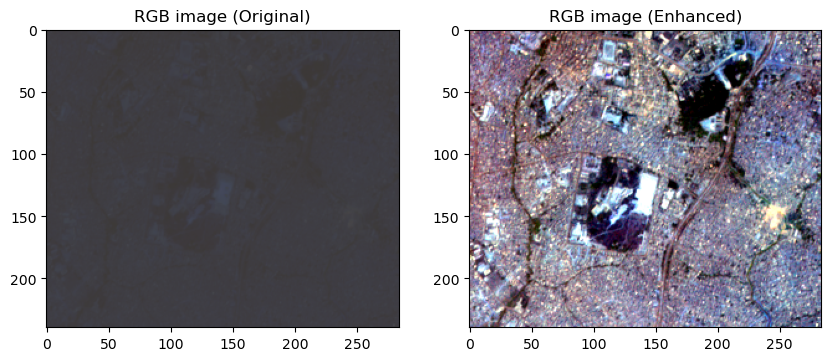

0

In [51]:
# Plot imagery
fig,(ax1, ax2)= plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("RGB image (Original)")
ax2.set_title("RGB image (Enhanced)")
ax1.imshow(data0[:, :, 0:3])
ax2.imshow(data_enhanced0[:, :, 0:3])
plt.show();

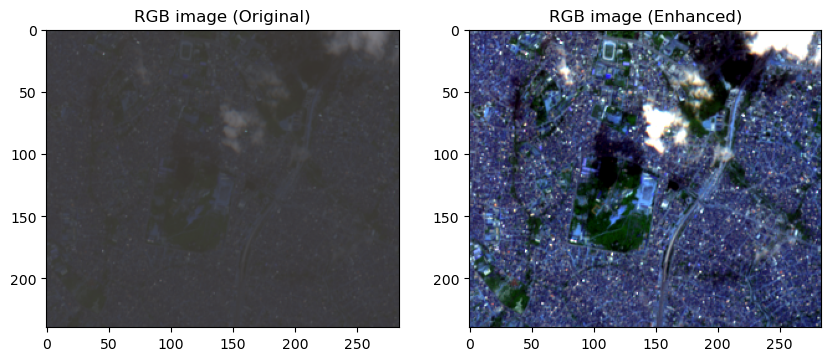

In [52]:
# Plot imagery
fig,(ax1, ax2)= plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("RGB image (Original)")
ax2.set_title("RGB image (Enhanced)")
ax1.imshow(data1[:, :, 0:3])
ax2.imshow(data_enhanced1[:, :, 0:3])
plt.show();

In [68]:
band1 = src_raster1.read(1)
print('Band1 has shape', band1.shape)
height = band1.shape[0]
width = band1.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rio.transform.xy(src_raster1.transform, rows, cols)
lons= np.array(xs)
lats = np.array(ys)
print('lons shape', lons.shape)

Band1 has shape (240, 284)
lons shape (240, 284)


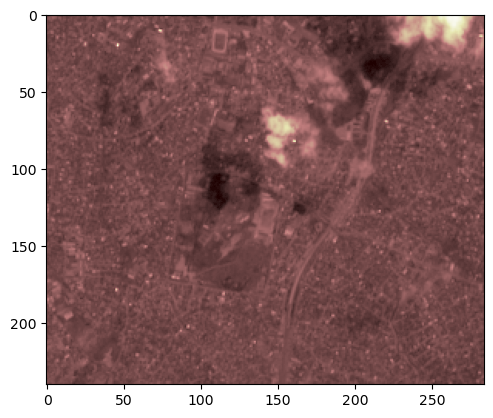

In [77]:
plt.imshow(src_raster1.read(2), cmap='pink')

In [79]:
from rasterio.plot import show

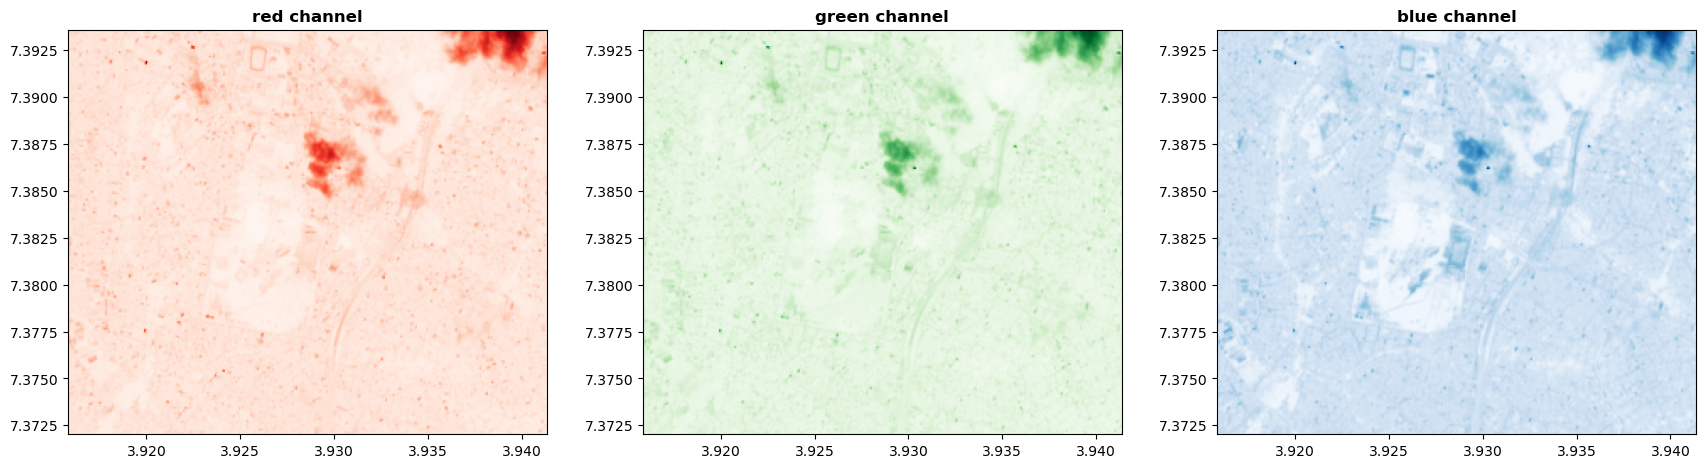

In [89]:
fig, (axr, axg, axb) = plt.subplots(1, 3, figsize=(21, 7))
show((src_raster1, 1), ax=axr, cmap='Reds', title='red channel')
show((src_raster1, 2), ax=axg, cmap='Greens', title='green channel')
show((src_raster1, 3), ax=axb, cmap='Blues', title='blue channel');


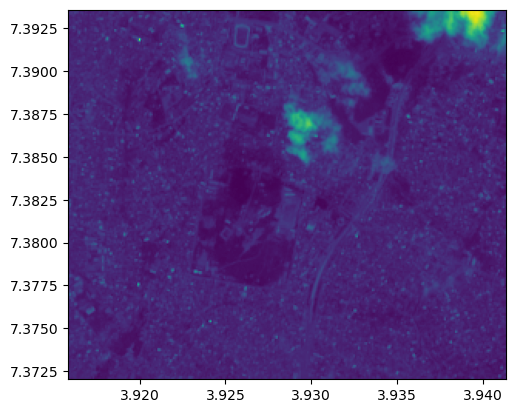

In [85]:
show(src_raster1, 2, cmap='viridis');

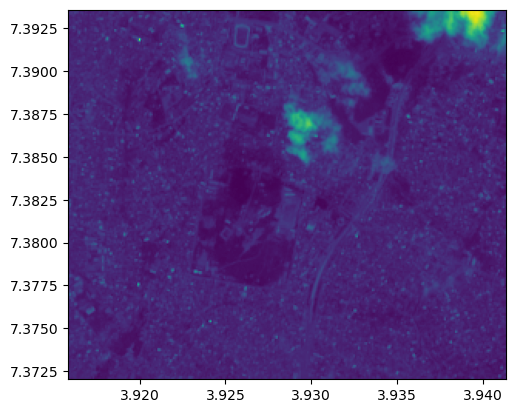

In [87]:
show(src_raster1.read(1), transform=src_raster1.transform, cmap='viridis');

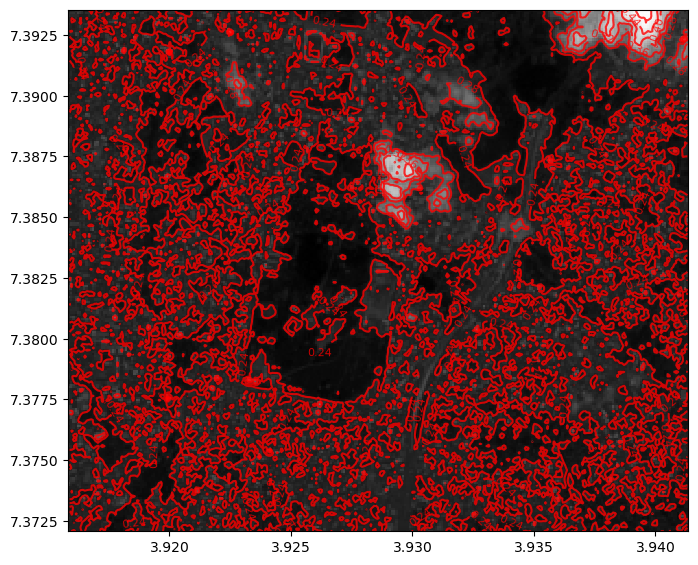

In [93]:
fig, ax = plt.subplots(1, figsize=(8, 8))
show((src_raster1, 1), cmap='Greys_r', interpolation='none', ax=ax)
show((src_raster1, 1), contour=True, ax=ax);

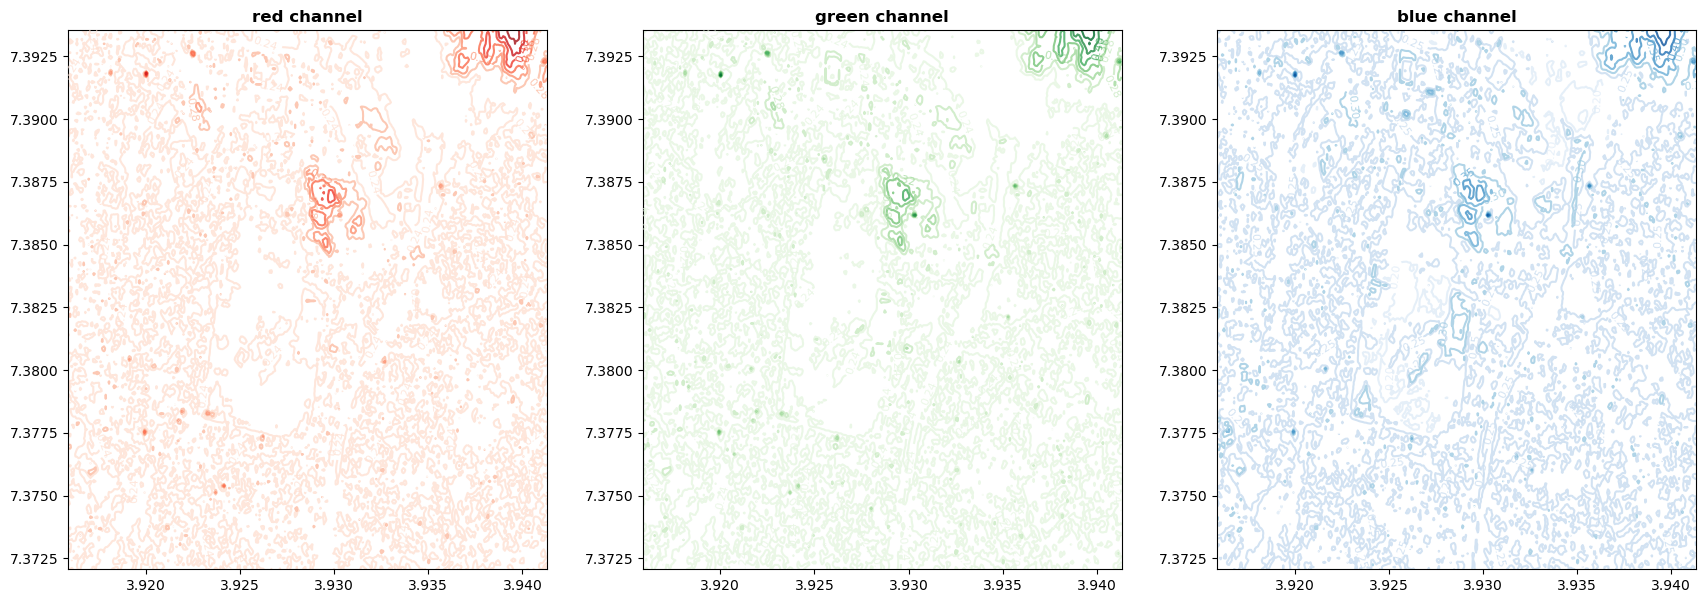

In [90]:
fig, (axr, axg, axb) = plt.subplots(1, 3, figsize=(21, 7))
show((src_raster1, 1), contour=True, ax=axr, cmap='Reds', title='red channel')
show((src_raster1, 2), contour=True, ax=axg, cmap='Greens', title='green channel')
show((src_raster1, 3), contour=True, ax=axb, cmap='Blues', title='blue channel');


In [14]:
from geotile import GeoTile

In [61]:
gt20200131 = GeoTile('../data-in/Sentinel-2/2020_tiff_images/2020-01-01_2020-01-31.tif')
gt20200131.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 415,
 'height': 826,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 3.906863002164211,
        0.0, -8.983152841195215e-05, 7.435086112072043)}

In [62]:
pwd

'/Users/ldjeutsch/Offliners/PYTHON-DATA-SCI/UM-Project/Abidjan/AbidjanPy/PyScripts/notebooks'

In [63]:
gt20200131.generate_tiles(save_tiles=False)
gt20200131.convert_nan_to_zero()
gt20200131.drop_nan_tiles()
gt20200131.drop_zero_value_tiles()
# gt20200131.save_tiles('../data-in/titles')
gt20200131.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 415,
 'height': 826,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 3.906863002164211,
        0.0, -8.983152841195215e-05, 7.435086112072043)}

In [64]:
geo_data = gt20200131.tile_data
print(geo_data.shape)
### Change the axis from (band, x, y) to (x, y, band)
# geo_data = np.transpose(geo_data, (1, 2, 0))
print(geo_data.shape)

(25, 256, 256, 4)
(25, 256, 256, 4)


In [65]:
### Preprocessing
geo_data_enhanced = np.zeros(geo_data[0, :, :, :].shape)
for i in range(data.shape[-1]):
    p2, p98 = np.percentile(geo_data[0, :, :, i], (2, 98))
    geo_data_enhanced[:, :, i] = exposure.rescale_intensity(geo_data[0, :, :, i], in_range=(p2, p98))

IndexError: index 4 is out of bounds for axis 3 with size 4

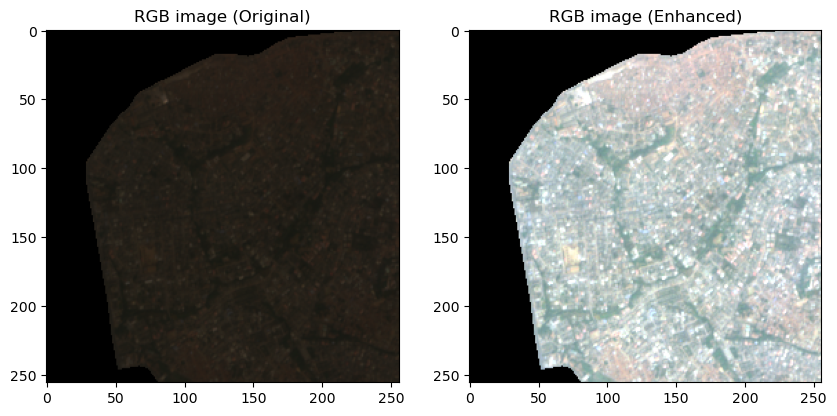

In [66]:
# Plot imagery
fig,(ax1, ax2)= plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("RGB image (Original)")
ax2.set_title("RGB image (Enhanced)")
ax1.imshow(geo_data[0, :, :, 0:3])
ax2.imshow(geo_data_enhanced[:, :, 0:3])
plt.show()

In [67]:
raster = rio.open("../data-in/Sentinel-2/2021_tiff_images/2021-01-01_2021-06-30.tif")

In [37]:
raster.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 415, 'height': 826, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 3.906863002164211,
       0.0, -8.983152841195215e-05, 7.435086112072043), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

## GEE and Download of Sentinel-2 Data

In [1]:
# Import necessary libraries
import ee
import geemap


ModuleNotFoundError: No module named 'ee'

In [ ]:

# Authenticate and initialize Earth Engine
ee.Initialize()

# Define the region of interest (ROI) using a GeoJSON geometry
roi_geometry = ee.Geometry.Polygon(
    [[[longitude1, latitude1],
      [longitude2, latitude2],
      [longitude3, latitude3],
      [longitude4, latitude4],
      [longitude1, latitude1]]])

# Load Sentinel-2 image collection for the specified time and location
sentinel2 = (ee.ImageCollection('COPERNICUS/S2')
             .filterBounds(roi_geometry)
             .filterDate('2022-01-01', '2022-12-31')
             .sort('CLOUDY_PIXEL_PERCENTAGE')
             .first())

# Select relevant bands for analysis
bands = ['B4', 'B3', 'B2', 'B8']  # NIR, Red, Green, SWIR

# Calculate vegetation indices
ndvi = sentinel2.normalizedDifference(['B8', 'B4']).rename('NDVI')
mndwi = sentinel2.normalizedDifference(['B3', 'B11']).rename('MNDWI')

# Define thresholds for land cover classification
ndvi_thresholds = [0.2, 0.4, 0.6, 0.8]
mndwi_thresholds = [0.1, 0.2, 0.3]

# Land cover classification based on thresholds
vegetation = ndvi.gt(ndvi_thresholds[2])
water = mndwi.lt(mndwi_thresholds[1])
bare_ground = ndvi.lt(ndvi_thresholds[1]).And(mndwi.gt(mndwi_thresholds[0]))
urban = ndvi.lt(ndvi_thresholds[0])

# Display the land cover classification using folium
Map = geemap.Map()
Map.centerObject(roi_geometry, zoom=10)
Map.addLayer(vegetation, {'palette': '00FF00'}, 'Vegetation')
Map.addLayer(water, {'palette': '0000FF'}, 'Water')
Map.addLayer(bare_ground, {'palette': 'FFFF00'}, 'Bare Ground')
Map.addLayer(urban, {'palette': 'FF0000'}, 'Urban')
Map.addLayerControl()
Map

# Export the land cover classification to Google Drive
geemap.ee_export_image_to_drive(vegetation, description='vegetation', folder='land_cover', region=roi_geometry, scale=10)
geemap.ee_export_image_to_drive(water, description='water', folder='land_cover', region=roi_geometry, scale=10)
geemap.ee_export_image_to_drive(bare_ground, description='bare_ground', folder='land_cover', region=roi_geometry, scale=10)
geemap.ee_export_image_to_drive(urban, description='urban', folder='land_cover', region=roi_geometry, scale=10)


## Updating a subset of raster values

Consider having a source raster data set (`.tif` file) and a number of polygon features. For each one of those polygons you need to:
1. 'clip' the raster.
2. change values of those clipped raster cells (with the average value).
3. write new values back to the source raster.

Two ways of achieving this are proposoed below.

#### Using `rioxarray`

```python
import numpy
import rioxarray
from shapely.geometry import mapping

xds = rioxarray.open_rasterio("NI_RIVER_ALR_1000.tif").sel(band=1).squeeze()
gdb_vml_polygs = 'RSA_VML_BUILDINGS_NI.gdb'
fc_vml_polygs = 'VML_Buildings_NI'
vml_polygs = gpd.read_file(gdb_vml_polygs, driver='FileGDB', layer=fc_vml_polygs)
out_xds = xds.copy()
for geom in vml_polygs.geometry.apply(mapping):
    clipped = xds.rio.clip([geom], vml_polygs.crs, drop=False)
    out_xds = out_xds.where(numpy.isnan(clipped), clipped.mean())
out_xds.rio.to_raster("out_averages.tif")
```

#### Using `rasterio`

```python
filled=False gives back masked array which can be utilised to replace with mean value.

Make sure to set crop=False and set the indexes to the band you want to replace it with.

import geopandas as gpd
import rasterio.mask
import rasterio as rio

gdf = gpd.read_file('input_shp.shp')

with rio.open("input.tif", "r") as src:
    band_num = 1
    src_image = src.read(band_num, out_dtype=rio.float64)

    # for each feature geom, replace with mean
    for geom in gdf.geometry:
        out_image, out_transform = rio.mask.mask(
            src, [geom], crop=False, filled=False, indexes=band_num
        )
        src_image[~out_image.mask] = src_image[~out_image.mask].mean()
    
    # save tif
    profile = src.profile
    profile.update(dtype=rio.float64, count=1, compress="lzw")

    with rasterio.open("output.tif", "w", **profile) as dst:
        dst.write(src_image, 1)
```

In [ ]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

api = SentinelAPI('user', 'password')
footprint = geojson_to_wkt(read_geojson('search_polygon.geojson'))
products = api.query(footprint,
                     producttype='SLC',
                     orbitdirection='ASCENDING',
                     limit=10)
api.download_all(products)